In [ ]:
# Import data processing libraries
import pandas as pd
import numpy as np

# One hot encoding and train-test split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

# Standardization Library
from sklearn.preprocessing import StandardScaler

# Search Space
from sklearn.model_selection import RandomizedSearchCV

# Plotting
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import rcParams
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# Import Light GBM
from lightgbm import LGBMClassifier

# Import Feature Selection Library
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from xverse.transformer import WOE

# Import Neural Network Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import SGD

# Comet Experiment
from comet_ml import Experiment
import configparser

# Save a model (for lgbm)
import joblib

In [ ]:
# Importing comet.ml
config = configparser.ConfigParser()
'''
File location of your key file, it can be placed anywhere but it should not the 
part of git due to privacy and security purposes
'''
config.read('keys\\comet_ml.ini')
API_KEY = config['comet_ml']['api_key']
PROJECT_NAME = config['comet_ml']['project_name']
WORKSPACE = config['comet_ml']['workspace']

In [ ]:
def dataload(train_link):
  """
  This finction is used for loading the data.
  params: train_link
  return: train_df
  """
  train_df = pd.read_csv(train_link)
  train_df.rename(columns={'game date':'game_date', 'period time':'period_time','game id':'game_id','home team':'home_team', 'away team':'away_team',
                          'is goal':'is_goal', 'team shot':'team_shot', 'x shot':'x_shot', 'y shot':'y_shot', 'shot type':'shot_type',
                          'empty net':'empty_net', 'home goal':'home_goal', 'away goal':'away_goal', 'is rebound':'is_rebound', 
                          'game seconds':'game_seconds', 'last event type':'last_event_type', 'x last event':'x_last_event',
                          'y last event':'y_last_event', 'time from last event':'time_from_last_event', 
                          'num player home':'num_player_home', 'num player away':'num_player_away', 'time power play':'time_power_play',
                          'shot distance':'shot_distance', 'shot angle':'shot_angle', 'change in shot angle':'change_in_shot_angle',
                          'distance from last event':'distance_from_last_event'}, inplace=True)
  return train_df

In [ ]:
path = '\\'.join(str(os.getcwd()).split('\\')[:-2])
read_csv_path = os.path.join(path, 'data\\processed\\df_feature_engineering.csv')
train_df = dataload(read_csv_path)

# Preprocessing of dataset
X = train_df.copy()
X['is_rebound'] = np.where(X['is_rebound'] == False, 0, 1)
X['is_goal'] = np.where(X['is_goal'] == False, 0, 1)
X['empty_net'] = np.where(X['empty_net'] == False, 0, 1)
transformer = make_column_transformer(
    (OneHotEncoder(), ['shot_type', 'last_event_type']), remainder='passthrough')
transformed = transformer.fit_transform(X)
transformed_X = pd.DataFrame(transformed, columns=transformer.get_feature_names())
y_numeric = transformed_X[['is_goal']]
transformed_X = transformed_X.drop(['game_date', 'is_goal', 'period_time', 
                                    'home_team', 'away_team', 'team_shot', 
                                    'shooter', 'goalie', 'rinkSide', 'strength'], axis=1)
trans_X = pd.concat((transformed_X, y_numeric), axis=1)
trans_X.dropna(inplace=True)
y_numeric = trans_X[['is_goal']]
transformed_X = trans_X.drop(['is_goal'], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Splitting the dataset for the selection of features
X_train, X_test, Y_train, y_test = train_test_split(transformed_X, y_numeric, test_size=0.2, shuffle=True, stratify=y_numeric, random_state=42)
# Change the datatype from object to it's numeric form
X_train[X_train.columns] = X_train[X_train.columns].apply(pd.to_numeric, errors='coerce')
Y_train=Y_train.astype('int')

In [ ]:
# Feature selection via RFE (Wrapper Method) with Logistic Regression
Y_train = np.ravel(Y_train)
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=25, step=1)
rfe_fit = rfe.fit(X_train, Y_train)
print("Num Features: %s" % (rfe_fit.n_features_))
print("Selected Features: %s" % (rfe_fit.support_))
print("Feature Ranking: %s" % (rfe_fit.ranking_))

Num Features: 25
Selected Features: [False False  True False False False  True False False  True False False
 False  True False False False False False False False False False False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
Feature Ranking: [ 7  6  1  2  3  9  1 11  4  1 16 12 14  1  5 15 13 17 18 19 20 10 21  8
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]


In [ ]:
selected_feature = pd.DataFrame()
selected_feature['features'] = X_train.columns
selected_feature['RFE_select'] = rfe_fit.support_
final_selected_feature = selected_feature.loc[selected_feature['RFE_select']==True]['features'].values
print(final_selected_feature)

['onehotencoder__x0_Slap Shot' 'onehotencoder__x0_Wrist Shot'
 'onehotencoder__x1_Faceoff' 'onehotencoder__x1_Hit' 'season' 'period'
 'game_id' 'x_shot' 'y_shot' 'empty_net' 'home_goal' 'away_goal'
 'is_rebound' 'game_seconds' 'x_last_event' 'y_last_event'
 'time_from_last_event' 'num_player_home' 'num_player_away'
 'time_power_play' 'shot_distance' 'shot_angle' 'change_in_shot_angle'
 'distance_from_last_event' 'speed']


In [ ]:
# Feature selection via RFE (Wrapper Method) with Random Forest Classifier
Y_train = np.ravel(Y_train)
model = RandomForestClassifier(random_state = 42)
rfe = RFE(model, n_features_to_select=25, step=1)
rfe_fit = rfe.fit(X_train, Y_train)
print("Num Features: %s" % (rfe_fit.n_features_))
print("Selected Features: %s" % (rfe_fit.support_))
print("Feature Ranking: %s" % (rfe_fit.ranking_))

Num Features: 25
Selected Features: [False False False  True False False  True False  True False False False
 False False  True False False False False False False  True False False
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True]
Feature Ranking: [ 8  9  7  1  5 11  1 12  1  2 20  3 14  4  1 15 13 16 17 18 19  1 21  6
  1  1  1  1  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1]


In [ ]:
selected_rfc_feature = pd.DataFrame()
selected_rfc_feature['features'] = X_train.columns
selected_rfc_feature['RFE_select'] = rfe_fit.support_
final_selected_rfc_feature = selected_rfc_feature.loc[selected_rfc_feature['RFE_select']==True]['features'].values
print(final_selected_rfc_feature)

['onehotencoder__x0_Snap Shot' 'onehotencoder__x0_Wrist Shot'
 'onehotencoder__x1_Blocked Shot' 'onehotencoder__x1_Missed Shot'
 'onehotencoder__x1_Shot' 'season' 'period' 'game_id' 'x_shot' 'y_shot'
 'empty_net' 'home_goal' 'away_goal' 'game_seconds' 'x_last_event'
 'y_last_event' 'time_from_last_event' 'num_player_home' 'num_player_away'
 'time_power_play' 'shot_distance' 'shot_angle' 'change_in_shot_angle'
 'distance_from_last_event' 'speed']


In [ ]:
# Weight of Evidence transformation dataset
# Feature selection via Weight of Evidence Technique (WOE)
# SOURCE: https://pypi.org/project/xverse/
clf = WOE()
clf.fit(X_train, Y_train)
print(clf.woe_df.head()) 

                 Variable_Name Category   Count  Event  Non_Event  Event_Rate  \
0   onehotencoder__x0_Backhand      0.0  219619  19730     199889    0.089837   
1   onehotencoder__x0_Backhand      1.0   18929   2034      16895    0.107454   
2  onehotencoder__x0_Deflected      0.0  234631  21091     213540    0.089890   
3  onehotencoder__x0_Deflected      1.0    3917    673       3244    0.171815   
4  onehotencoder__x0_Slap Shot      0.0  200814  19379     181435    0.096502   

   Non_Event_Rate  Event_Distribution  Non_Event_Distribution       WOE  \
0        0.910163            0.906543                0.922065 -0.016978   
1        0.892546            0.093457                0.077935  0.181631   
2        0.910110            0.969077                0.985036 -0.016334   
3        0.828185            0.030923                0.014964  0.725827   
4        0.903498            0.890415                0.836939  0.061937   

   Information_Value  
0           0.003083  
1           0.00

In [ ]:
# Information value dataset
print(clf.iv_df)

                           Variable_Name  Information_Value
37                         shot_distance       4.276722e-01
42                                x_shot       2.668235e-01
44                                y_shot       2.621623e-01
6                              home_goal       1.332589e-01
7                             is_rebound       7.763324e-02
1                   change_in_shot_angle       7.606639e-02
0                              away_goal       7.155658e-02
39                  time_from_last_event       6.099375e-02
36                            shot_angle       4.210308e-02
14              onehotencoder__x0_Tip-In       3.856064e-02
2               distance_from_last_event       3.098943e-02
38                                 speed       2.677774e-02
12           onehotencoder__x0_Slap Shot       2.456506e-02
40                       time_power_play       2.205246e-02
19             onehotencoder__x1_Faceoff       1.976655e-02
31                onehotencoder__x1_Shot

In [ ]:
# Select only strong features: Information value should be 0.3 to 0.5
woe_feature_select = pd.DataFrame(clf.iv_df)
woe_feature_select[(woe_feature_select['Information_Value']>0.3) & (woe_feature_select['Information_Value']<0.5)]

,Variable_Name,Information_Value
37,shot_distance,0.427672


In [ ]:
# Feature Selection via Select K Best Method
select = SelectKBest(score_func=mutual_info_classif, k=25)
z = select.fit_transform(X_train, Y_train)
 
print("After selecting best 3 features:", z.shape)

After selecting best 3 features: (238548, 25)


In [ ]:
# https://www.datatechnotes.com/2021/02/seleckbest-feature-selection-example-in-python.html#:~:text=The%20SelectKBest%20method%20selects%20the,a%20large%20dataset%20for%20training.
filter = select.get_support()
features = X_train.columns
print("All features:")
print(features)
print("Selected best 25:")
# print(filter)
print(features[filter])
print(z)

All features:
Index(['onehotencoder__x0_Backhand', 'onehotencoder__x0_Deflected',
       'onehotencoder__x0_Slap Shot', 'onehotencoder__x0_Snap Shot',
       'onehotencoder__x0_Tip-In', 'onehotencoder__x0_Wrap-around',
       'onehotencoder__x0_Wrist Shot', 'onehotencoder__x0_nan',
       'onehotencoder__x1_Blocked Shot', 'onehotencoder__x1_Faceoff',
       'onehotencoder__x1_Game Official', 'onehotencoder__x1_Giveaway',
       'onehotencoder__x1_Goal', 'onehotencoder__x1_Hit',
       'onehotencoder__x1_Missed Shot', 'onehotencoder__x1_Official Challenge',
       'onehotencoder__x1_Penalty', 'onehotencoder__x1_Period End',
       'onehotencoder__x1_Period Ready', 'onehotencoder__x1_Period Start',
       'onehotencoder__x1_Shootout Complete', 'onehotencoder__x1_Shot',
       'onehotencoder__x1_Stoppage', 'onehotencoder__x1_Takeaway', 'season',
       'period', 'game_id', 'x_shot', 'y_shot', 'empty_net', 'home_goal',
       'away_goal', 'is_rebound', 'game_seconds', 'x_last_event',
     

In [ ]:
# Extracting feature list
feature_list = []
for colname in features[filter]:
  feature_list.append(colname)

In [ ]:
# Choosing common features which were given by all the different algorithms
final_feature_selected_list = list(set(final_selected_feature).intersection(final_selected_rfc_feature, feature_list))
print(final_feature_selected_list)

['onehotencoder__x0_Wrist Shot', 'y_last_event', 'x_shot', 'home_goal', 'shot_distance', 'distance_from_last_event', 'y_shot', 'season', 'game_seconds', 'speed', 'num_player_away', 'num_player_home', 'change_in_shot_angle', 'empty_net', 'shot_angle', 'period', 'time_from_last_event', 'x_last_event', 'away_goal']


In [ ]:
def dataset_split(transformed_X, y_numeric):
  """
  This function is for splitting the dataset.
  params: transformed_X, y_numeric
  return: X_train, X_test, Y_train, y_test
  """
  # Split the dataset with the selected features
  X_train, X_test, Y_train, y_test = train_test_split(transformed_X[final_feature_selected_list], 
                                                      y_numeric, test_size=0.2, shuffle=True, stratify=y_numeric)
  # Turn the object datatype columns to numeric form
  Y_train=Y_train.astype('int')
  X_train[X_train.columns] = X_train[X_train.columns].apply(pd.to_numeric, errors='coerce')
  y_test=y_test.astype('int')
  X_test[X_test.columns] = X_test[X_test.columns].apply(pd.to_numeric, errors='coerce')
  return X_train, X_test, Y_train, y_test

In [ ]:
def dataset_standardization(X_train):
  """
  This function is used for standardizing the dataset.
  params: X_train
  return: X_train_scaled, X_test_scaled
  """
  # Standardize the columns
  X_scaler = StandardScaler().fit(X_train)
  X_train_scaled = X_scaler.transform(X_train)
  X_test_scaled = X_scaler.transform(X_test)
  return X_train_scaled, X_test_scaled

Starting Neural Network Application

In [ ]:
# Splitting and Standardizing the dataset
X_train, X_test, Y_train, y_test = dataset_split(transformed_X[final_feature_selected_list], y_numeric)
X_train_scaled, X_test_scaled = dataset_standardization(X_train)

In [ ]:
# Split the remaining data to train and validation
x_train, x_val, y_train, y_val = train_test_split(X_train_scaled, Y_train, test_size=0.1, shuffle=True, stratify=Y_train)

In [ ]:
# Layers addition with regularization and batch normalization
np.random.seed(42)
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=x_train.shape[1]))
model.add(BatchNormalization())
model.add(Dense(8, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=1, activation="sigmoid"))

In [ ]:
# Compile the model using binary_crossentropy for the loss function, the SGD optimizer,
# and add accuracy to the training metrics
np.random.seed(42)
opt = SGD(learning_rate=0.01)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Smaller batch size will result into smaller accuracy
np.random.seed(42)
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
1678/1678 [==============================] - 11s 5ms/step - loss: 0.3911 - accuracy: 0.8957 - val_loss: 0.3274 - val_accuracy: 0.9121
Epoch 2/100
1678/1678 [==============================] - 7s 4ms/step - loss: 0.3080 - accuracy: 0.9119 - val_loss: 0.2934 - val_accuracy: 0.9122
Epoch 3/100
1678/1678 [==============================] - 7s 4ms/step - loss: 0.2813 - accuracy: 0.9123 - val_loss: 0.2756 - val_accuracy: 0.9122
Epoch 4/100
1678/1678 [==============================] - 7s 4ms/step - loss: 0.2668 - accuracy: 0.9122 - val_loss: 0.2668 - val_accuracy: 0.9122
Epoch 5/100
1678/1678 [==============================] - 7s 4ms/step - loss: 0.2597 - accuracy: 0.9124 - val_loss: 0.2606 - val_accuracy: 0.9128
Epoch 6/100
1678/1678 [==============================] - 7s 4ms/step - loss: 0.2561 - accuracy: 0.9126 - val_loss: 0.2582 - val_accuracy: 0.9127
Epoch 7/100
1678/1678 [==============================] - 7s 4ms/step - loss: 0.2537 - accuracy: 0.9126 - val_loss: 0.2579 - val_a

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: keras, sklearn, lightgbm, tensorboard, tensorflow. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/anshitasaxena/milestone-project-2/69f92d4c35bc41508edfd2dfc880e41a
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1ZY4TP_1tQ48Vx0E-aCE5kklUsWKQo0Zc
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (28.80 KB)
COMET INFO:     notebook            : 2
COMET INFO:     os packages         : 1
COM

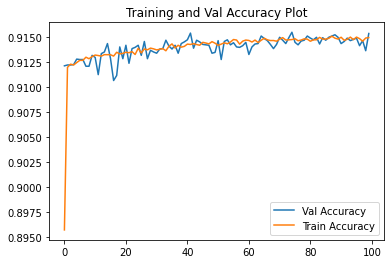

In [ ]:
# Experiment entry for logging the neural network
experiment_nn = Experiment(
    api_key=API_KEY,
    project_name=PROJECT_NAME,
    workspace=WORKSPACE
)
path = '\\'.join(str(os.getcwd()).split('\\')[:-2])
model_path = os.path.join(path, 'models')
filename = model_path + 'neural_network.h5'
model.save(filename)
experiment_nn.log_model("Neural_Network", filename)
# Plot the accuracy graph
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('Training and Val Accuracy Plot')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.legend()
experiment_nn.log_figure(figure_name="Accuracy Curve Neural Network", 
                         overwrite=False, step=None)
plt.show()

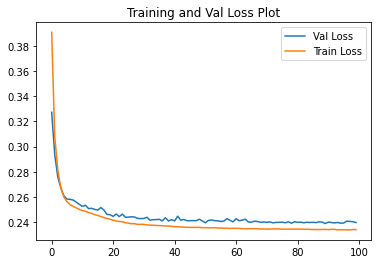

In [ ]:
# Plot the loss graph
plt.title('Training and Val Loss Plot')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['loss'], label='Train Loss')
plt.legend()
experiment_nn.log_figure(figure_name="Loss Curve Neural Network", 
                         overwrite=False, step=None)
plt.show()

In [ ]:
# Evaluate the model
model_loss, model_accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
experiment_nn.log_metric("Neural Network accuracy: ", model_accuracy)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1864/1864 - 3s - loss: 0.2367 - accuracy: 0.9148 - 3s/epoch - 2ms/step
Loss: 0.2367246150970459, Accuracy: 0.9147844314575195


In [ ]:
# Store the prediction probabilities of goal rate
probs = model.predict(X_test_scaled)
predictions = np.round(probs)

1864/1864 [==============================] - 3s 1ms/step


No Skill: ROC AUC=0.500
Neural Network: ROC AUC=0.832


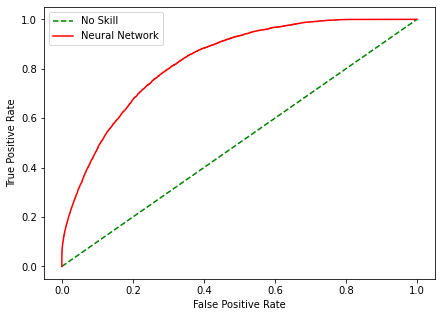

In [ ]:
# Plot AUC ROC Curve
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)# generate a no skill prediction (majority class)
# Source: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
nn_auc = roc_auc_score(y_test, probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Neural Network: ROC AUC=%.3f' % (nn_auc))
# calculate roc curves
plt.figure(figsize=(7, 5))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color='green')
plt.plot(nn_fpr, nn_tpr, linestyle='-', label='Neural Network', color='red')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
experiment_nn.log_figure(figure_name="AUC_ROC Neural Network", 
                         overwrite=False, step=None)
plt.show()

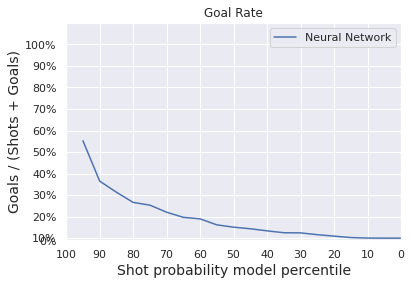

In [ ]:
# Plotting Goal Rate versus Shot Probability Percentile
# Convert 2-D to 1-D series
new_series = np.array(y_test)
new_series = np.reshape(new_series, (new_series.shape[0]))

# Scale true_probabilities (predict_proba() returns true and false both) on percentile
true_prob = pd.DataFrame()
true_prob['true_target'] = np.array(new_series)
percentile = [[np.percentile(probs, i), np.percentile(probs, i+5)] 
              for i in range(0,100,5)]
total_goal = np.sum(new_series)
# print(percentile)

# Looping on probabilities to check their percentiles with their status as goal/shot
goal_probability = []
# print(true_prob.shape)
for i in range(0, len(percentile)):
    # Check the interval of probability in percentile and calculate the number of goals
    true_prob_percentile = true_prob[(probs<=percentile[i][1]) & (probs>percentile[i][0])]
    goals = true_prob_percentile.loc[true_prob_percentile['true_target']==1].shape[0]
    # Check the interval of probability in percentile and calculate the number of no goals (or shots)
    no_goals = true_prob_percentile.loc[true_prob_percentile['true_target']==0].shape[0]
    # If no goal, do nothing, calculate the formula if goal
    if goals == 0:
        goal_probability.append(0)
    else:
        goal_probability.append((goals*100)/(goals+no_goals))

# Axis for percentile
shot_prob_model_percentile = np.arange(0, 100, 5)
    
# Plot of goal rate vs Shot probability percentile
fig_goal_rate = plt.figure()
sns.set()
plt.plot(shot_prob_model_percentile, goal_probability, label='Neural Network')
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.title("Goal Rate")
plt.xlabel('Shot probability model percentile', fontsize=14)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.ylabel('Goals / (Shots + Goals)', fontsize=14)
y_axis = [-1,0,10,20,30,40,50,60,70,80,90,100]
y_values = ['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']
plt.yticks(y_axis, y_values)
plt.legend()
experiment_nn.log_figure(figure_name="Goal Rate versus Shot Probability Model Percentile Neural Network", 
                         overwrite=False, step=None)
plt.show()

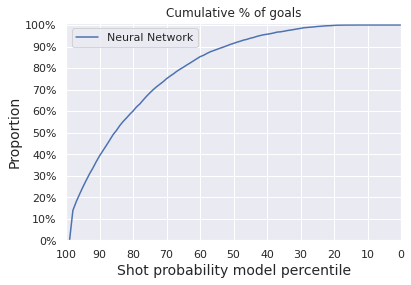

In [ ]:
# Plotting Cumulative Percentage goals versus Proportion
# Convert 2-D to 1-D series
new_series = np.array(y_test)
new_series = np.reshape(new_series, (new_series.shape[0]))

# Scale true_probabilities (predict_proba() returns true and false both) on percentile
true_prob = pd.DataFrame()
true_prob['true_target'] = np.array(new_series)
percentile = [[np.percentile(probs, i), np.percentile(probs, i+1)] 
              for i in range(0,100,1)]
total_goal = np.sum(new_series)

# Looping on probabilities to check their percentiles with their status as goal/shot
cum_prop = []
for i in range(0, len(percentile)-1):
    # We need previous and current goal lie in the percentile
    true_prob_percentile = true_prob[(probs>=percentile[i][0])]
    goals = true_prob_percentile.loc[true_prob_percentile['true_target']==1].shape[0]
    # If no goal, do nothing, calculate the formula if goal
    cum_prop.append(goals*100/total_goal)
cum_prop.append(0)

# Axis for percentile
shot_prob_model_percentile = np.arange(0, 100, 1)
    
# Plot of cumulative frequency vs Shot probability percentile
fig_cum_shot = plt.figure()
sns.set()
plt.plot(shot_prob_model_percentile, cum_prop, label='Neural Network')
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.title("Cumulative % of goals")
plt.xlabel('Shot probability model percentile', fontsize=14)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.ylabel('Proportion', fontsize=14)
y_axis = [0,10,20,30,40,50,60,70,80,90,100,101]
y_values = ['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']
plt.yticks(y_axis, y_values)
plt.legend(loc='upper left')
experiment_nn.log_figure(figure_name="Cumulative Shot Probability Neural Network", 
                         overwrite=False, step=None)
plt.show()

<Figure size 576x360 with 0 Axes>

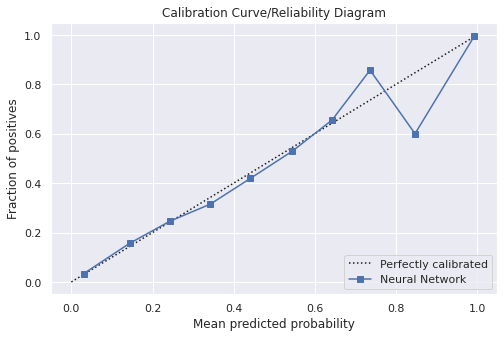

<Figure size 576x360 with 0 Axes>

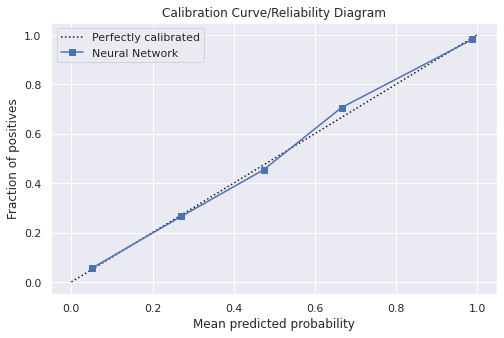

In [ ]:
# Plotted Caliberated Curves for checking the reliability
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)
plt.rcParams["figure.figsize"] = (8,5)
fig_cal1 = plt.figure()
disp1 = CalibrationDisplay(prob_true, prob_pred, probs)
# disp1.savefig("Calibration Curve or Reliability 1 Diagram Base.png")
plt1 = disp1.plot(label='Neural Network')
plt.title("Calibration Curve/Reliability Diagram")
experiment_nn.log_figure(figure_name="Caliberative Curve 1 Neural Network", 
                        overwrite=False, step=None)

fig_cal3 = plt.figure()
disp3 = CalibrationDisplay.from_predictions(y_test, probs, name='Neural Network')
plt.title("Calibration Curve/Reliability Diagram")
plt.legend(loc='upper left')
experiment_nn.log_figure(figure_name="Caliberative Curve 2 Neural Network", 
                        overwrite=False, step=None)
plt.show()
caliberation_display_neural = [y_test, probs, 'neural_network']

In [ ]:
experiment_nn.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/anshitasaxena/milestone-project-2/2293637ebf3241f2af343b27d683c694
COMET INFO:   Metrics:
COMET INFO:     Neural Network accuracy:  : 0.9147844314575195
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1ZY4TP_1tQ48Vx0E-aCE5kklUsWKQo0Zc
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 7
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (28.80 KB)
COMET INFO:     notebook            : 2
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has b

Light GBM

In [ ]:
# Splitting and standardizing the dataset
X_train, X_test, Y_train, y_test = dataset_split(transformed_X[final_feature_selected_list], y_numeric)
X_train_scaled, X_test_scaled = dataset_standardization(X_train)

In [ ]:
# Running the LGBM Classifier for hyperparameter tuning
lgbm_mdl = LGBMClassifier(objective="binary" ,class_weight={0:0.2,1:0.8,},
                       metric="auc", random_state=42
                      )
params = {'min_gain_to_split':[0.1, 0.3, 0.5, 0.6],"reg_alpha" :[0.4, 1],
"reg_lambda" : [0.7, 1],}
model = RandomizedSearchCV(lgbm_mdl, params, random_state=42, cv=5)
Y_train = np.ravel(Y_train)
model.fit(X_train_scaled, Y_train)

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight={0: 0.2, 1: 0.8},
                                            metric='auc', objective='binary',
                                            random_state=42),
                   param_distributions={'min_gain_to_split': [0.1, 0.3, 0.5,
                                                              0.6],
                                        'reg_alpha': [0.4, 1],
                                        'reg_lambda': [0.7, 1]},
                   random_state=42)

In [ ]:
# Best parameter set for LGBM Classifier
print('Best parameters found:\n', model.best_params_)

Best parameters found:
 {'reg_lambda': 1, 'reg_alpha': 0.4, 'min_gain_to_split': 0.1}


In [ ]:
# Run the algorithm for training and prediction
model = LGBMClassifier(class_weight={0: 0.2, 1: 0.8}, metric='auc',
               min_gain_to_split=0.1, objective='binary', random_state=42,
               reg_alpha=0.4, reg_lambda=1)
model.fit(X_train_scaled, Y_train)
y_pred = model.predict(X_test_scaled)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Experiment entry for logging the Light GBM
experiment_lgbm = Experiment(
    api_key=API_KEY,
    project_name=PROJECT_NAME,
    workspace=WORKSPACE
)
path = '\\'.join(str(os.getcwd()).split('\\')[:-2])
model_path = os.path.join(path, 'models')
filename = model_path + 'light_gbm.pkl'
# save model
joblib.dump(model, filename)
experiment_lgbm.log_model("Light_GBM", filename)
experiment_lgbm.log_metric("Light GBM accuracy: ", accuracy)
y_tr_pred = model.predict(X_train_scaled)
lgbm_probs = model.predict_proba(X_test_scaled)
probs = lgbm_probs[:, 1]

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: keras, sklearn, lightgbm, tensorboard, tensorflow. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()


Accuracy: 86.90%


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/anshitasaxena/milestone-project-2/d8787f8ada134fcf8eeef4468e958f11
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1ZY4TP_1tQ48Vx0E-aCE5kklUsWKQo0Zc
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 2
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: keras, sklearn, lightgbm, tensorboard, tensorflow. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and 

[[49063  5133]
 [ 2677  2764]]


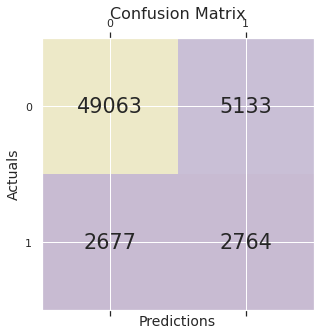

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


{'web': 'https://www.comet.com/api/asset/download?assetId=31d7053cf4d24f09a757bdb2773fcd49&experimentKey=87a4c37a5adc49c19962861cf41a5507',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=31d7053cf4d24f09a757bdb2773fcd49&experimentKey=87a4c37a5adc49c19962861cf41a5507',
 'assetId': '31d7053cf4d24f09a757bdb2773fcd49'}

In [ ]:
# Plot the confusion matrix
# SOURCE: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_matrix)
fig, ax = plt.subplots(figsize=(7, 5))
ax.matshow(conf_matrix, cmap=plt.cm.viridis, alpha=0.2)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()
print(type(y_test))
print(type(model.predict(X_test_scaled)))
experiment_lgbm.log_confusion_matrix(matrix=conf_matrix)

In [ ]:
# Classification Report showing the classification metrics
print('Test Classification Report:')
print(classification_report(y_test, model.predict(X_test_scaled)))
print('Train Classification Report:')
print(classification_report(Y_train, model.predict(X_train_scaled)))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     54196
           1       0.35      0.51      0.41      5441

    accuracy                           0.87     59637
   macro avg       0.65      0.71      0.67     59637
weighted avg       0.89      0.87      0.88     59637

Train Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93    216784
           1       0.37      0.54      0.44     21764

    accuracy                           0.88    238548
   macro avg       0.66      0.72      0.69    238548
weighted avg       0.90      0.88      0.89    238548



{'web': 'https://www.comet.com/api/image/download?imageId=8437c31cc4e644df81586349e9620587&experimentKey=87a4c37a5adc49c19962861cf41a5507',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=8437c31cc4e644df81586349e9620587&experimentKey=87a4c37a5adc49c19962861cf41a5507',
 'imageId': '8437c31cc4e644df81586349e9620587'}

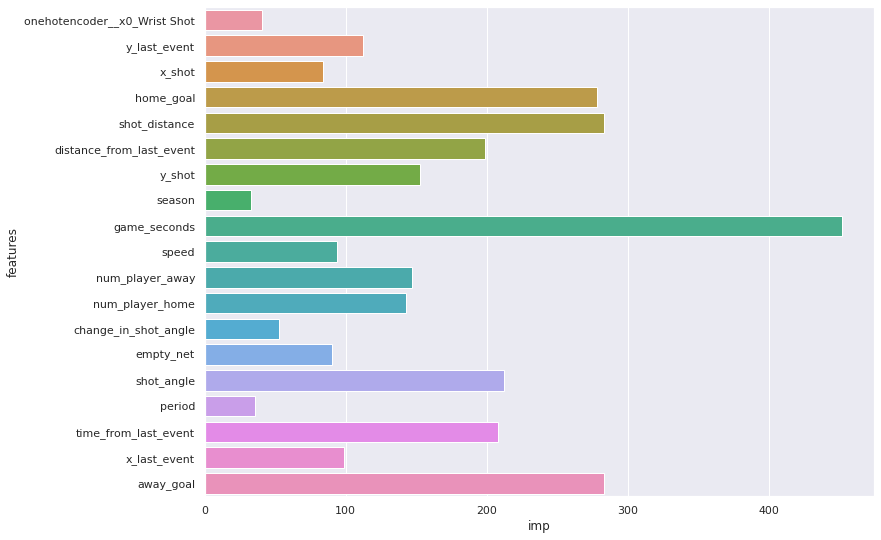

In [ ]:
# Plot the feature importances, game_seconds is a strong feature for prediction
feature_imp = pd.DataFrame()
feature_imp['features'] = X_train.columns
feature_imp['imp'] = model.feature_importances_

# figure size in inches
rcParams['figure.figsize'] = 12,9
ax = sns.barplot(x="imp", y="features", data=feature_imp)
experiment_lgbm.log_figure(figure_name="Bar Plot Light GBM", 
                           overwrite=False, step=None)

No Skill: ROC AUC=0.500
Light GBM: ROC AUC=0.847


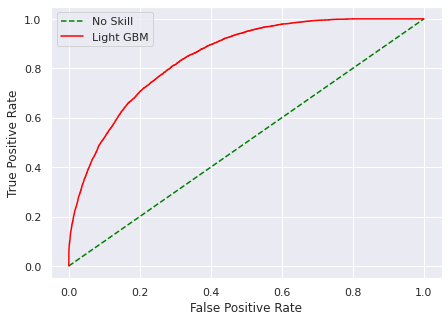

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


<Figure size 864x648 with 0 Axes>

In [ ]:
# Plotting ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)# generate a no skill prediction (majority class)
# Source: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lgbm_auc = roc_auc_score(y_test, probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Light GBM: ROC AUC=%.3f' % (lgbm_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, probs)
# plot the roc curve for the model
plt.figure(figsize=(7, 5))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color='green')
plt.plot(nn_fpr, nn_tpr, linestyle='-', label='Light GBM', color='red')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
experiment_lgbm.log_figure(figure_name="AUC ROC Light GBM", 
                           overwrite=False, step=None)

{'web': 'https://www.comet.com/api/image/download?imageId=14f3f366107e40d482736d99757b3bf2&experimentKey=87a4c37a5adc49c19962861cf41a5507',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=14f3f366107e40d482736d99757b3bf2&experimentKey=87a4c37a5adc49c19962861cf41a5507',
 'imageId': '14f3f366107e40d482736d99757b3bf2'}

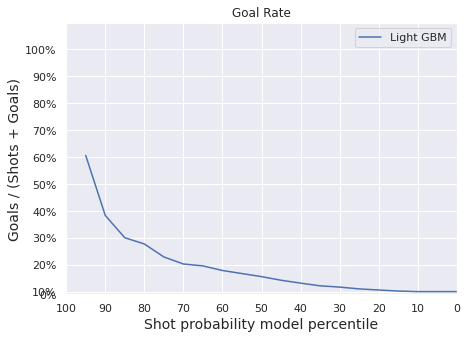

In [ ]:
# Plotting Goal Rate versus Shot probability model percentile
# Convert 2-D to 1-D series
new_series = np.array(y_test)
new_series = np.reshape(new_series, (new_series.shape[0]))

# Scale true_probabilities (predict_proba() returns true and false both) on percentile
true_prob = pd.DataFrame()
true_prob['true_target'] = np.array(new_series)
percentile = [[np.percentile(probs, i), np.percentile(probs, i+5)] 
              for i in range(0,100,5)]
total_goal = np.sum(new_series)
# print(percentile)

# Looping on probabilities to check their percentiles with their status as goal/shot
goal_probability = []
# print(true_prob.shape)
for i in range(0, len(percentile)):
    # Check the interval of probability in percentile and calculate the number of goals
    true_prob_percentile = true_prob[(probs<=percentile[i][1]) & (probs>percentile[i][0])]
    goals = true_prob_percentile.loc[true_prob_percentile['true_target']==1].shape[0]
    # Check the interval of probability in percentile and calculate the number of no goals (or shots)
    no_goals = true_prob_percentile.loc[true_prob_percentile['true_target']==0].shape[0]
    # If no goal, do nothing, calculate the formula if goal
    if goals == 0:
        goal_probability.append(0)
    else:
        goal_probability.append((goals*100)/(goals+no_goals))

# Axis for percentile
shot_prob_model_percentile = np.arange(0, 100, 5)
    
# Plot of goal rate vs Shot probability percentile
fig_goal_rate = plt.figure(figsize=(7, 5))
sns.set()
plt.plot(shot_prob_model_percentile, goal_probability, label='Light GBM')
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.title("Goal Rate")
plt.xlabel('Shot probability model percentile', fontsize=14)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.ylabel('Goals / (Shots + Goals)', fontsize=14)
y_axis = [-1,0,10,20,30,40,50,60,70,80,90,100]
y_values = ['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']
plt.yticks(y_axis, y_values)
plt.legend()
experiment_lgbm.log_figure(figure_name="Goal versus Shot Probability Model Percentile Light GBM", 
                           overwrite=False, step=None)

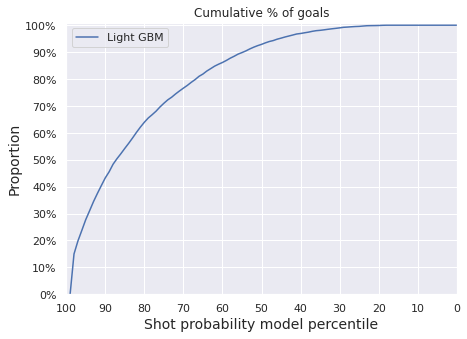

In [ ]:
# Plot the cumulative proportion of goals
# Convert 2-D to 1-D series
new_series = np.array(y_test)
new_series = np.reshape(new_series, (new_series.shape[0]))

# Scale true_probabilities (predict_proba() returns true and false both) on percentile
true_prob = pd.DataFrame()
true_prob['true_target'] = np.array(new_series)
percentile = [[np.percentile(probs, i), np.percentile(probs, i+1)] 
              for i in range(0,100,1)]
total_goal = np.sum(new_series)

# Looping on probabilities to check their percentiles with their status as goal/shot
cum_prop = []
for i in range(0, len(percentile)-1):
    # We need previous and current goal lie in the percentile
    true_prob_percentile = true_prob[(probs>=percentile[i][0])]
    goals = true_prob_percentile.loc[true_prob_percentile['true_target']==1].shape[0]
    # If no goal, do nothing, calculate the formula if goal
    cum_prop.append(goals*100/total_goal)
cum_prop.append(0)

# Axis for percentile
shot_prob_model_percentile = np.arange(0, 100, 1)
    
# Plot of cumulative frequency vs Shot probability percentile
fig_cum_shot = plt.figure(figsize=(7, 5))
sns.set()
plt.plot(shot_prob_model_percentile, cum_prop, label='Light GBM')
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.title("Cumulative % of goals")
plt.xlabel('Shot probability model percentile', fontsize=14)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.ylabel('Proportion', fontsize=14)
y_axis = [0,10,20,30,40,50,60,70,80,90,100,101]
y_values = ['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']
plt.yticks(y_axis, y_values)
plt.legend(loc='upper left')
experiment_lgbm.log_figure(figure_name="Cumulative Proportion of Goals Light GBM", 
                           overwrite=False, step=None)
plt.show()

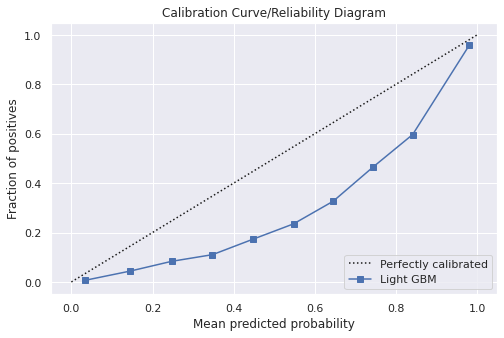

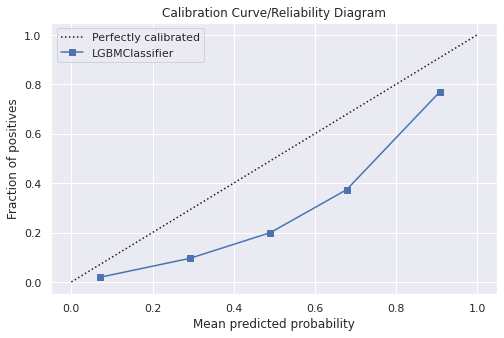

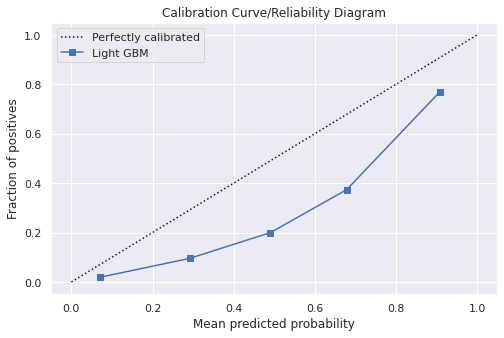

In [ ]:
# Plot reliability curves
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)
plt.rcParams["figure.figsize"] = (8,5)
disp1 = CalibrationDisplay(prob_true, prob_pred, probs)
# disp1.savefig("Calibration Curve or Reliability 1 Diagram Base.png")
plt1 = disp1.plot(label='Light GBM')
plt.title("Calibration Curve/Reliability Diagram")
experiment_lgbm.log_figure(figure_name="Caliberative Curve 1 Light GBM", 
                           overwrite=False, step=None)

disp2 = CalibrationDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title("Calibration Curve/Reliability Diagram")
plt.legend(loc='upper left')
experiment_lgbm.log_figure(figure_name="Caliberative Curve 2 Light GBM", 
                           overwrite=False, step=None)
plt.show()

disp3 = CalibrationDisplay.from_predictions(y_test, probs, name='Light GBM')
plt.title("Calibration Curve/Reliability Diagram")
plt.legend(loc='upper left')
experiment_lgbm.log_figure(figure_name="Caliberative Curve 3 Light GBM", 
                           overwrite=False, step=None)
plt.show()
caliberation_display_lightgbm = [y_test, probs, 'light_gbm']

{'web': 'https://www.comet.com/api/image/download?imageId=45a228ffc13c4eb6908baacc7a247edd&experimentKey=87a4c37a5adc49c19962861cf41a5507',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=45a228ffc13c4eb6908baacc7a247edd&experimentKey=87a4c37a5adc49c19962861cf41a5507',
 'imageId': '45a228ffc13c4eb6908baacc7a247edd'}

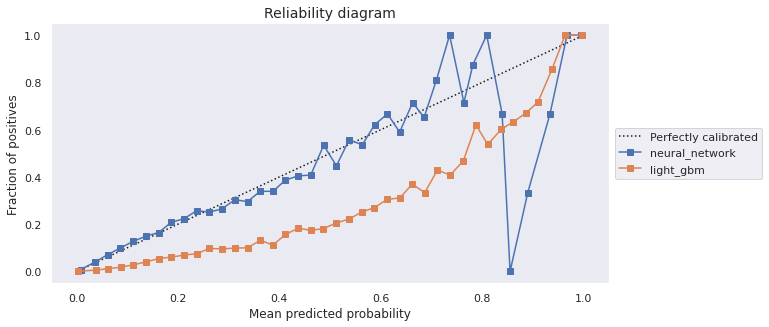

In [ ]:
# Plot the reliability caliberative curve comparison between neural network and LGBM
caliberation_list = []
caliberation_list.append(caliberation_display_neural)
caliberation_list.append(caliberation_display_lightgbm)

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for y_test, clf, name in caliberation_list:
    display = CalibrationDisplay.from_predictions(
        y_test,
        clf,
        name=name,
        n_bins=40,
        ax=ax_calibration_curve,
        
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Reliability diagram",fontsize=14)
experiment_lgbm.log_figure(figure_name="Caliberative Curve comparison between Light GBM and Neural Network", 
                           overwrite=False, step=None)

In [ ]:
experiment_lgbm.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/anshitasaxena/milestone-project-2/87a4c37a5adc49c19962861cf41a5507
COMET INFO:   Metrics:
COMET INFO:     Light GBM accuracy:  : 0.8690410315743582
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1ZY4TP_1tQ48Vx0E-aCE5kklUsWKQo0Zc
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix    : 9
COMET INFO:     environment details : 1
COMET INFO:     figures             : 7
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (262.35 KB)
COMET INFO:     notebook            : 2
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled au

Starting Random Forest Classifier Model

In [ ]:
# Splitting and standardizing the dataset
X_train, X_test, Y_train, y_test = dataset_split(transformed_X[final_feature_selected_list], y_numeric)
X_train_scaled, X_test_scaled = dataset_standardization(X_train)

In [ ]:
Y_train = np.ravel(Y_train)

In [ ]:
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train_scaled, Y_train)

RandomForestClassifier(random_state=42)

In [ ]:
rf_default.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
rf = RandomForestClassifier(random_state=42)

In [ ]:
#selecting hyperparameters for tuning the model
params =  {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [2, 4, 6, 8, 16],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 5],
    'bootstrap': [True, False],
    'criterion' : ['gini', 'entropy'],
}

In [ ]:
model = RandomizedSearchCV(rf, params, random_state=42, cv=5)

In [ ]:
Y_train = np.ravel(Y_train)

In [ ]:
model.fit(X_train_scaled, Y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 4, 6, 8, 16],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   random_state=42)

In [ ]:
# Best parameter set for randomforest Classifier
print('Best parameters found:\n', model.best_params_)

Best parameters found:
 {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 8, 'criterion': 'entropy', 'bootstrap': True}


In [ ]:
model = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=200, 
                               max_features ='log2',  bootstrap= True,
               min_samples_split=10, min_samples_leaf=5, random_state=42)

In [ ]:
model.fit(X_train_scaled, Y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, max_features='log2',
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [ ]:
y_pred = model.predict(X_test_scaled)

In [ ]:
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

filename = 'randomforest.pkl'
# # save model
joblib.dump(model, filename)

#log experiment in comet.ml
experiment.log_model("randomforest", filename)
experiment.log_metric("randomforest accuracy: ", accuracy)
y_tr_pred = model.predict(X_train_scaled)
dt_probs = model.predict_proba(X_test_scaled)
probs = dt_probs[:, 1]

Accuracy: 91.34%


In [ ]:
# Plot the confusion matrix
# SOURCE: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_matrix)
fig, ax = plt.subplots(figsize=(7, 5))
ax.matshow(conf_matrix, cmap=plt.cm.viridis, alpha=0.2)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()
print(type(y_test))
print(type(model.predict(X_test_scaled)))
experiment.log_confusion_matrix(matrix=conf_matrix)

[[54196     0]
 [ 5165   276]]
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


{'web': 'https://www.comet.com/api/asset/download?assetId=09f98a281e444834ba078b9a753689a7&experimentKey=bbf64965ddd444dbba743b6ffcb469f0',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=09f98a281e444834ba078b9a753689a7&experimentKey=bbf64965ddd444dbba743b6ffcb469f0',
 'assetId': '09f98a281e444834ba078b9a753689a7'}

In [ ]:
# Classification Report showing the classification metrics
print('Test Classification Report:')
print(classification_report(y_test, model.predict(X_test_scaled)))
print('Train Classification Report:')
print(classification_report(Y_train, model.predict(X_train_scaled)))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     54196
           1       1.00      0.05      0.10      5441

    accuracy                           0.91     59637
   macro avg       0.96      0.53      0.53     59637
weighted avg       0.92      0.91      0.88     59637

Train Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95    216784
           1       1.00      0.05      0.10     21764

    accuracy                           0.91    238548
   macro avg       0.96      0.53      0.53    238548
weighted avg       0.92      0.91      0.88    238548



In [ ]:
# Plot the feature importances, game_seconds is a strong feature for prediction
feature_imp = pd.DataFrame()
feature_imp['features'] = X_train.columns
feature_imp['imp'] = model.feature_importances_

# figure size in inches
rcParams['figure.figsize'] = 12,9
ax = sns.barplot(x="imp", y="features", data=feature_imp)
experiment.log_figure(figure_name="Bar Plot RandomForest", 
                           overwrite=False, step=None)

{'web': 'https://www.comet.com/api/image/download?imageId=3ef75babf6224bc4907e3eaa322c379c&experimentKey=bbf64965ddd444dbba743b6ffcb469f0',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=3ef75babf6224bc4907e3eaa322c379c&experimentKey=bbf64965ddd444dbba743b6ffcb469f0',
 'imageId': '3ef75babf6224bc4907e3eaa322c379c'}

In [ ]:
# Plotting ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)# generate a no skill prediction (majority class)
# Source: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('RandomForest: ROC AUC=%.3f' % (rf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, probs)
# plot the roc curve for the model
plt.figure(figsize=(7, 5))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color='green')
plt.plot(nn_fpr, nn_tpr, linestyle='-', label='RandomForest', color='red')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
experiment.log_figure(figure_name="AUC ROC RandomForest", 
                           overwrite=False, step=None)

No Skill: ROC AUC=0.500
RandomForest: ROC AUC=0.827


{'web': 'https://www.comet.com/api/image/download?imageId=7a8c8fd7ab1c497591068c2824dc6c0c&experimentKey=bbf64965ddd444dbba743b6ffcb469f0',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=7a8c8fd7ab1c497591068c2824dc6c0c&experimentKey=bbf64965ddd444dbba743b6ffcb469f0',
 'imageId': '7a8c8fd7ab1c497591068c2824dc6c0c'}

In [ ]:
# Plotting Goal Rate versus Shot probability model percentile
# Convert 2-D to 1-D series
new_series = np.array(y_test)
new_series = np.reshape(new_series, (new_series.shape[0]))

# Scale true_probabilities (predict_proba() returns true and false both) on percentile
true_prob = pd.DataFrame()
true_prob['true_target'] = np.array(new_series)
percentile = [[np.percentile(probs, i), np.percentile(probs, i+5)] 
              for i in range(0,100,5)]
total_goal = np.sum(new_series)
# print(percentile)

# Looping on probabilities to check their percentiles with their status as goal/shot
goal_probability = []
# print(true_prob.shape)
for i in range(0, len(percentile)):
    # Check the interval of probability in percentile and calculate the number of goals
    true_prob_percentile = true_prob[(probs<=percentile[i][1]) & (probs>percentile[i][0])]
    goals = true_prob_percentile.loc[true_prob_percentile['true_target']==1].shape[0]
    # Check the interval of probability in percentile and calculate the number of no goals (or shots)
    no_goals = true_prob_percentile.loc[true_prob_percentile['true_target']==0].shape[0]
    # If no goal, do nothing, calculate the formula if goal
    if goals == 0:
        goal_probability.append(0)
    else:
        goal_probability.append((goals*100)/(goals+no_goals))

# Axis for percentile
shot_prob_model_percentile = np.arange(0, 100, 5)
    
# Plot of goal rate vs Shot probability percentile
fig_goal_rate = plt.figure(figsize=(7, 5))
sns.set()
plt.plot(shot_prob_model_percentile, goal_probability, label='RandomForest')
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.title("Goal Rate")
plt.xlabel('Shot probability model percentile', fontsize=14)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.ylabel('Goals / (Shots + Goals)', fontsize=14)
y_axis = [0,10,20,30,40,50,60,70,80,90,100]
y_values = ['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']
plt.yticks(y_axis, y_values)
plt.legend()
experiment.log_figure(figure_name="Goal versus Shot Probability Model Percentile RandomForest", 
                           overwrite=False, step=None)

{'web': 'https://www.comet.com/api/image/download?imageId=9a2ca9c9c7614fe9ac802d8906214c90&experimentKey=bbf64965ddd444dbba743b6ffcb469f0',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=9a2ca9c9c7614fe9ac802d8906214c90&experimentKey=bbf64965ddd444dbba743b6ffcb469f0',
 'imageId': '9a2ca9c9c7614fe9ac802d8906214c90'}

In [ ]:
# Plot the cumulative proportion of goals
# Convert 2-D to 1-D series
new_series = np.array(y_test)
new_series = np.reshape(new_series, (new_series.shape[0]))

# Scale true_probabilities (predict_proba() returns true and false both) on percentile
true_prob = pd.DataFrame()
true_prob['true_target'] = np.array(new_series)
percentile = [[np.percentile(probs, i), np.percentile(probs, i+1)] 
              for i in range(0,100,1)]
total_goal = np.sum(new_series)

# Looping on probabilities to check their percentiles with their status as goal/shot
cum_prop = []
for i in range(0, len(percentile)-1):
    # We need previous and current goal lie in the percentile
    true_prob_percentile = true_prob[(probs>=percentile[i][0])]
    goals = true_prob_percentile.loc[true_prob_percentile['true_target']==1].shape[0]
    # If no goal, do nothing, calculate the formula if goal
    cum_prop.append(goals*100/total_goal)
cum_prop.append(0)

# Axis for percentile
shot_prob_model_percentile = np.arange(0, 100, 1)
    
# Plot of cumulative frequency vs Shot probability percentile
fig_cum_shot = plt.figure(figsize=(7, 5))
sns.set()
plt.plot(shot_prob_model_percentile, cum_prop, label='RandomForest')
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.title("Cumulative % of goals")
plt.xlabel('Shot probability model percentile', fontsize=14)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.ylabel('Proportion', fontsize=14)
y_axis = [0,10,20,30,40,50,60,70,80,90,100]
y_values = ['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']
plt.yticks(y_axis, y_values)
plt.legend(loc='upper left')
experiment.log_figure(figure_name="Cumulative Proportion of Goals RandomForest", 
                           overwrite=False, step=None)
plt.show()

In [ ]:
# Plot reliability curves
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)
plt.rcParams["figure.figsize"] = (8,5)
disp1 = CalibrationDisplay(prob_true, prob_pred, probs)
#disp1.savefig("Calibration Curve or Reliability 1 Diagram Base.png")
plt1 = disp1.plot(label='RandomForest')
plt.title("Calibration Curve/Reliability Diagram")
experiment.log_figure(figure_name="Caliberative Curve 1 RandomForest", 
                           overwrite=False, step=None)

disp2 = CalibrationDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title("Calibration Curve/Reliability Diagram")
plt.legend(loc='upper left')
experiment.log_figure(figure_name="Caliberative Curve 2 RandomForest", 
                           overwrite=False, step=None)
plt.show()

disp3 = CalibrationDisplay.from_predictions(y_test, probs, name='RandomForest')
plt.title("Calibration Curve/Reliability Diagram")
plt.legend(loc='upper left')
experiment.log_figure(figure_name="Caliberative Curve 3 RandomForest", 
                           overwrite=False, step=None)
plt.show()
caliberation_display_RandomForest = [y_test, probs, 'RandomForest']

In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/anshitasaxena/milestone-project-2/bbf64965ddd444dbba743b6ffcb469f0
COMET INFO:   Metrics:
COMET INFO:     randomforest accuracy:  : 0.9133926924560256
COMET INFO:   Others:
COMET INFO:     Name         : randomforest
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1suNOxGC9DDN3QRKmpNe8UkKlEIGhkk6W
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix    : 1
COMET INFO:     environment details : 1
COMET INFO:     figures             : 8
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (3.95 MB)
COMET INFO:     notebook            : 2
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: -------------------

Starting Decision Tree Classifier Model

In [ ]:
# Splitting and standardizing the dataset
X_train, X_test, Y_train, y_test = dataset_split(transformed_X[final_feature_selected_list], y_numeric)
X_train_scaled, X_test_scaled = dataset_standardization(X_train)

In [ ]:
Y_train = np.ravel(Y_train)

In [ ]:
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train_scaled, Y_train)

RandomForestClassifier(random_state=42)

In [ ]:
rf_default.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
rf = RandomForestClassifier(random_state=42)

In [ ]:
#selecting hyperparameters for tuning the model
params =  {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [2, 4, 6, 8, 16],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 5],
    'bootstrap': [True, False],
    'criterion' : ['gini', 'entropy'],
}

In [ ]:
model = RandomizedSearchCV(rf, params, random_state=42, cv=5)

In [ ]:
Y_train = np.ravel(Y_train)

In [ ]:
model.fit(X_train_scaled, Y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 4, 6, 8, 16],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   random_state=42)

In [ ]:
# Best parameter set for randomforest Classifier
print('Best parameters found:\n', model.best_params_)

Best parameters found:
 {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 8, 'criterion': 'entropy', 'bootstrap': True}


In [ ]:
model = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=200, 
                               max_features ='log2',  bootstrap= True,
               min_samples_split=10, min_samples_leaf=5, random_state=42)

In [ ]:
model.fit(X_train_scaled, Y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, max_features='log2',
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [ ]:
y_pred = model.predict(X_test_scaled)

In [ ]:
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
filename = 'randomforest.pkl'
# # save model
joblib.dump(model, filename)

#log experiment in comet.ml
experiment.log_model("randomforest", filename)
experiment.log_metric("randomforest accuracy: ", accuracy)
y_tr_pred = model.predict(X_train_scaled)
dt_probs = model.predict_proba(X_test_scaled)
probs = dt_probs[:, 1]

Accuracy: 91.34%


In [ ]:
# Plot the confusion matrix
# SOURCE: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_matrix)
fig, ax = plt.subplots(figsize=(7, 5))
ax.matshow(conf_matrix, cmap=plt.cm.viridis, alpha=0.2)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()
print(type(y_test))
print(type(model.predict(X_test_scaled)))
experiment.log_confusion_matrix(matrix=conf_matrix)

[[54196     0]
 [ 5165   276]]
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


{'web': 'https://www.comet.com/api/asset/download?assetId=09f98a281e444834ba078b9a753689a7&experimentKey=bbf64965ddd444dbba743b6ffcb469f0',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=09f98a281e444834ba078b9a753689a7&experimentKey=bbf64965ddd444dbba743b6ffcb469f0',
 'assetId': '09f98a281e444834ba078b9a753689a7'}

In [ ]:
# Classification Report showing the classification metrics
print('Test Classification Report:')
print(classification_report(y_test, model.predict(X_test_scaled)))
print('Train Classification Report:')
print(classification_report(Y_train, model.predict(X_train_scaled)))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     54196
           1       1.00      0.05      0.10      5441

    accuracy                           0.91     59637
   macro avg       0.96      0.53      0.53     59637
weighted avg       0.92      0.91      0.88     59637

Train Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95    216784
           1       1.00      0.05      0.10     21764

    accuracy                           0.91    238548
   macro avg       0.96      0.53      0.53    238548
weighted avg       0.92      0.91      0.88    238548



In [ ]:
# Plot the feature importances, game_seconds is a strong feature for prediction
feature_imp = pd.DataFrame()
feature_imp['features'] = X_train.columns
feature_imp['imp'] = model.feature_importances_

# figure size in inches
rcParams['figure.figsize'] = 12,9
ax = sns.barplot(x="imp", y="features", data=feature_imp)
experiment.log_figure(figure_name="Bar Plot RandomForest", 
                           overwrite=False, step=None)

{'web': 'https://www.comet.com/api/image/download?imageId=3ef75babf6224bc4907e3eaa322c379c&experimentKey=bbf64965ddd444dbba743b6ffcb469f0',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=3ef75babf6224bc4907e3eaa322c379c&experimentKey=bbf64965ddd444dbba743b6ffcb469f0',
 'imageId': '3ef75babf6224bc4907e3eaa322c379c'}

In [ ]:
# Plotting ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)# generate a no skill prediction (majority class)
# Source: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('RandomForest: ROC AUC=%.3f' % (rf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, probs)
# plot the roc curve for the model
plt.figure(figsize=(7, 5))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color='green')
plt.plot(nn_fpr, nn_tpr, linestyle='-', label='RandomForest', color='red')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
experiment.log_figure(figure_name="AUC ROC RandomForest", 
                           overwrite=False, step=None)

No Skill: ROC AUC=0.500
RandomForest: ROC AUC=0.827


{'web': 'https://www.comet.com/api/image/download?imageId=7a8c8fd7ab1c497591068c2824dc6c0c&experimentKey=bbf64965ddd444dbba743b6ffcb469f0',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=7a8c8fd7ab1c497591068c2824dc6c0c&experimentKey=bbf64965ddd444dbba743b6ffcb469f0',
 'imageId': '7a8c8fd7ab1c497591068c2824dc6c0c'}

In [ ]:
# Plotting Goal Rate versus Shot probability model percentile
# Convert 2-D to 1-D series
new_series = np.array(y_test)
new_series = np.reshape(new_series, (new_series.shape[0]))

# Scale true_probabilities (predict_proba() returns true and false both) on percentile
true_prob = pd.DataFrame()
true_prob['true_target'] = np.array(new_series)
percentile = [[np.percentile(probs, i), np.percentile(probs, i+5)] 
              for i in range(0,100,5)]
total_goal = np.sum(new_series)
# print(percentile)

# Looping on probabilities to check their percentiles with their status as goal/shot
goal_probability = []
# print(true_prob.shape)
for i in range(0, len(percentile)):
    # Check the interval of probability in percentile and calculate the number of goals
    true_prob_percentile = true_prob[(probs<=percentile[i][1]) & (probs>percentile[i][0])]
    goals = true_prob_percentile.loc[true_prob_percentile['true_target']==1].shape[0]
    # Check the interval of probability in percentile and calculate the number of no goals (or shots)
    no_goals = true_prob_percentile.loc[true_prob_percentile['true_target']==0].shape[0]
    # If no goal, do nothing, calculate the formula if goal
    if goals == 0:
        goal_probability.append(0)
    else:
        goal_probability.append((goals*100)/(goals+no_goals))

# Axis for percentile
shot_prob_model_percentile = np.arange(0, 100, 5)
    
# Plot of goal rate vs Shot probability percentile
fig_goal_rate = plt.figure(figsize=(7, 5))
sns.set()
plt.plot(shot_prob_model_percentile, goal_probability, label='RandomForest')
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.title("Goal Rate")
plt.xlabel('Shot probability model percentile', fontsize=14)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.ylabel('Goals / (Shots + Goals)', fontsize=14)
y_axis = [0,10,20,30,40,50,60,70,80,90,100]
y_values = ['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']
plt.yticks(y_axis, y_values)
plt.legend()
experiment.log_figure(figure_name="Goal versus Shot Probability Model Percentile RandomForest", 
                           overwrite=False, step=None)

{'web': 'https://www.comet.com/api/image/download?imageId=9a2ca9c9c7614fe9ac802d8906214c90&experimentKey=bbf64965ddd444dbba743b6ffcb469f0',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=9a2ca9c9c7614fe9ac802d8906214c90&experimentKey=bbf64965ddd444dbba743b6ffcb469f0',
 'imageId': '9a2ca9c9c7614fe9ac802d8906214c90'}

In [ ]:
# Plot the cumulative proportion of goals
# Convert 2-D to 1-D series
new_series = np.array(y_test)
new_series = np.reshape(new_series, (new_series.shape[0]))

# Scale true_probabilities (predict_proba() returns true and false both) on percentile
true_prob = pd.DataFrame()
true_prob['true_target'] = np.array(new_series)
percentile = [[np.percentile(probs, i), np.percentile(probs, i+1)] 
              for i in range(0,100,1)]
total_goal = np.sum(new_series)

# Looping on probabilities to check their percentiles with their status as goal/shot
cum_prop = []
for i in range(0, len(percentile)-1):
    # We need previous and current goal lie in the percentile
    true_prob_percentile = true_prob[(probs>=percentile[i][0])]
    goals = true_prob_percentile.loc[true_prob_percentile['true_target']==1].shape[0]
    # If no goal, do nothing, calculate the formula if goal
    cum_prop.append(goals*100/total_goal)
cum_prop.append(0)

# Axis for percentile
shot_prob_model_percentile = np.arange(0, 100, 1)
    
# Plot of cumulative frequency vs Shot probability percentile
fig_cum_shot = plt.figure(figsize=(7, 5))
sns.set()
plt.plot(shot_prob_model_percentile, cum_prop, label='RandomForest')
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.title("Cumulative % of goals")
plt.xlabel('Shot probability model percentile', fontsize=14)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.ylabel('Proportion', fontsize=14)
y_axis = [0,10,20,30,40,50,60,70,80,90,100]
y_values = ['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']
plt.yticks(y_axis, y_values)
plt.legend(loc='upper left')
experiment.log_figure(figure_name="Cumulative Proportion of Goals RandomForest", 
                           overwrite=False, step=None)
plt.show()

In [ ]:
# Plot reliability curves
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)
plt.rcParams["figure.figsize"] = (8,5)
disp1 = CalibrationDisplay(prob_true, prob_pred, probs)
#disp1.savefig("Calibration Curve or Reliability 1 Diagram Base.png")
plt1 = disp1.plot(label='RandomForest')
plt.title("Calibration Curve/Reliability Diagram")
experiment.log_figure(figure_name="Caliberative Curve 1 RandomForest", 
                           overwrite=False, step=None)

disp2 = CalibrationDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title("Calibration Curve/Reliability Diagram")
plt.legend(loc='upper left')
experiment.log_figure(figure_name="Caliberative Curve 2 RandomForest", 
                           overwrite=False, step=None)
plt.show()

disp3 = CalibrationDisplay.from_predictions(y_test, probs, name='RandomForest')
plt.title("Calibration Curve/Reliability Diagram")
plt.legend(loc='upper left')
experiment.log_figure(figure_name="Caliberative Curve 3 RandomForest", 
                           overwrite=False, step=None)
plt.show()
caliberation_display_RandomForest = [y_test, probs, 'RandomForest']

In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/anshitasaxena/milestone-project-2/bbf64965ddd444dbba743b6ffcb469f0
COMET INFO:   Metrics:
COMET INFO:     randomforest accuracy:  : 0.9133926924560256
COMET INFO:   Others:
COMET INFO:     Name         : randomforest
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1suNOxGC9DDN3QRKmpNe8UkKlEIGhkk6W
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix    : 1
COMET INFO:     environment details : 1
COMET INFO:     figures             : 8
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (3.95 MB)
COMET INFO:     notebook            : 2
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: -------------------